In [1]:
from ay_torch import *
import os
%matplotlib widget

In [2]:
'''
Generate the dataset by:
$ ./gen_sqptn1.py
$ nano gen_sqptn1.py    #switch the train/test constant.
$ ./gen_sqptn1.py
'''
class SqPtn1Dataset(torch.utils.data.Dataset):
  def __init__(self, root='data_generated/sqptn1/', transform=None, train=True):
    self.transform= transform
    self.image_paths= []
    self.labels= []
    self.root= root
    self.MakePathLabelList(train)

  def LoadLabel(self, filepath):
    with open(filepath,'r') as fp:
      return float(fp.read().strip())

  def MakePathLabelList(self, train):
    dir_train= 'train' if train else 'test'
    image_paths__labels= [
        (os.path.join(self.root, dir_train, 'images', filename),
         self.LoadLabel(os.path.join(self.root, dir_train, 'labels', filename+'.dat')) )
        for filename in os.listdir(os.path.join(self.root, dir_train, 'images')) ]
    self.image_paths= [image_path for image_path,label in image_paths__labels]
    self.labels= [label for image_path,label in image_paths__labels]

  def __getitem__(self, index):
    with open(self.image_paths[index],'rb') as f:
      img= PILImage.open(f)
      img= img.convert('RGB')
    img= img if self.transform is None else self.transform(img)
    tr_value= lambda v: torch.autograd.Variable(torch.tensor([v]))
    return img, tr_value(self.labels[index])

  def __len__(self):
    return len(self.image_paths)

def GetDataTransforms(mode):
  if mode=='train':
    return torchvision.transforms.Compose([
        #torchvision.transforms.RandomResizedCrop(224),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        # torchvision.transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
      ])
  if mode=='eval':
    return torchvision.transforms.Compose([
        #torchvision.transforms.Resize(256),
        #torchvision.transforms.CenterCrop(224),
        torchvision.transforms.ToTensor(),
        # torchvision.transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
      ])
  if mode=='none':
    return torchvision.transforms.Compose([
        #torchvision.transforms.RandomResizedCrop(224),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor()
      ])

In [3]:
dset_train= SqPtn1Dataset(transform=GetDataTransforms('train'), train=True)
dset_test= SqPtn1Dataset(transform=GetDataTransforms('eval'), train=False)
#NOTE: Adjust the batch and epoch sizes.
n_batch= 10
dl_train= torch.utils.data.DataLoader(
              dataset=dset_train,
              batch_size=n_batch,
              shuffle=True,
              num_workers=2)
dl_test= torch.utils.data.DataLoader(
              dataset=dset_test,
              batch_size=n_batch,
              shuffle=False,
              num_workers=2)

In [4]:
print('dset_train size:',len(dset_train))
print('dset_train[0] input type, shape:',type(dset_train[0][0]),dset_train[0][0].shape)
print('dset_train[0] label value:',dset_train[0][1])
#print('dset_train[0][0] value:',dset_train[0][0][:,100:110,100:110])
print('dset_train[0][0] value range:',torch.min(dset_train[0][0]),torch.max(dset_train[0][0]))
print('dset_test size:',len(dset_test))
print('dset_test[0] input type, shape:',type(dset_test[0][0]),dset_test[0][0].shape)
print('dset_test[0] label value:',dset_test[0][1])
print('dset_test[0][0] value range:',torch.min(dset_test[0][0]),torch.max(dset_test[0][0]))

dset_train size: 400
dset_train[0] input type, shape: <class 'torch.Tensor'> torch.Size([3, 200, 200])
dset_train[0] label value: tensor([0.2776])
dset_train[0][0] value range: tensor(0.) tensor(1.)
dset_test size: 200
dset_test[0] input type, shape: <class 'torch.Tensor'> torch.Size([3, 200, 200])
dset_test[0] label value: tensor([0.4745])
dset_test[0][0] value range: tensor(0.) tensor(1.)


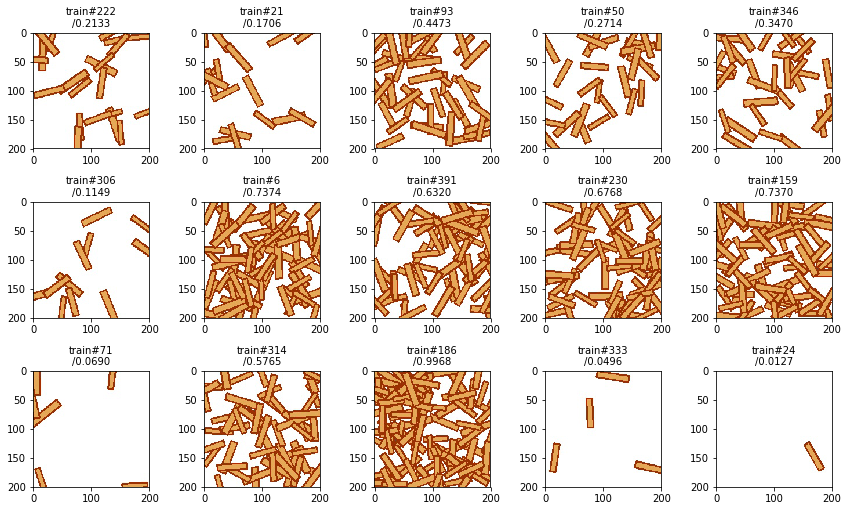

In [5]:
d= dset_train
idxes= np.random.permutation(len(d))[:15]
imgs= [d[i][0] for i in idxes]
labels= [f'train#{i}\n/{d[i][1].item():.4f}' for i in idxes]
PlotImgGrid(imgs, labels)

In [6]:
class TAlexNet(torch.nn.Module):
  def __init__(self, img_shape, p_dropout=0.02):
    super(TAlexNet,self).__init__()
    self.net_features= torch.nn.Sequential(
          #torch.nn.Conv2d(in_channels, out_channels, ...)
          torch.nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
          torch.nn.ReLU(inplace=True),
          torch.nn.MaxPool2d(kernel_size=2, stride=2),
          torch.nn.Conv2d(64, 192, kernel_size=5, padding=2),
          torch.nn.ReLU(inplace=True),
          torch.nn.MaxPool2d(kernel_size=2, stride=2),
          torch.nn.Conv2d(192, 384, kernel_size=3, padding=1),
          torch.nn.ReLU(inplace=True),
          torch.nn.Conv2d(384, 256, kernel_size=3, padding=1),
          torch.nn.ReLU(inplace=True),
          torch.nn.Conv2d(256, 256, kernel_size=3, padding=1),
          torch.nn.ReLU(inplace=True),
          torch.nn.MaxPool2d(kernel_size=2, stride=2),
          )
    n_feat_out= self.net_features(torch.FloatTensor(*((1,)+img_shape))).view(1,-1).shape[1]
    self.net_estimator= torch.nn.Sequential(
          torch.nn.Dropout(p=p_dropout),
          torch.nn.Linear(n_feat_out, 4096),
          torch.nn.ReLU(inplace=True),
          torch.nn.Dropout(p=p_dropout),
          torch.nn.Linear(4096, 4096),
          torch.nn.ReLU(inplace=True),
          torch.nn.Linear(4096, 1)
          )

  def forward(self, x):
    x= self.net_features(x)
    x= x.view(x.size(0), -1)
    return self.net_estimator(x)

In [7]:
#Setup a neural network.
net= TAlexNet(img_shape=dset_train[0][0].shape)

device= torch.device('cuda')

#Setup an optimizer and a loss function.
opt= torch.optim.Adam(net.parameters(), lr=0.01)
f_loss= torch.nn.MSELoss()

def decode(pred):
  return pred

def rmse(y,y_trg):
  return torch.sqrt(torch.nn.functional.mse_loss(y,y_trg))
f_metric= rmse

def tfm_batch(batch):
  x,y= batch
  return x,y
logger= TLogger()
disp= TDisp()

/home/akihikoy/.local/lib/python3.6/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [9]:
input_size= (1,)+dset_train[0][0].shape
print(f'input_size={input_size}')
torchinfo.summary(net, input_size)

input_size=(1, 3, 200, 200)


Layer (type:depth-idx)                   Output Shape              Param #
TAlexNet                                 --                        --
├─Sequential: 1-1                        [1, 256, 6, 6]            --
│    └─Conv2d: 2-1                       [1, 64, 49, 49]           23,296
│    └─ReLU: 2-2                         [1, 64, 49, 49]           --
│    └─MaxPool2d: 2-3                    [1, 64, 24, 24]           --
│    └─Conv2d: 2-4                       [1, 192, 24, 24]          307,392
│    └─ReLU: 2-5                         [1, 192, 24, 24]          --
│    └─MaxPool2d: 2-6                    [1, 192, 12, 12]          --
│    └─Conv2d: 2-7                       [1, 384, 12, 12]          663,936
│    └─ReLU: 2-8                         [1, 384, 12, 12]          --
│    └─Conv2d: 2-9                       [1, 256, 12, 12]          884,992
│    └─ReLU: 2-10                        [1, 256, 12, 12]          --
│    └─Conv2d: 2-11                      [1, 256, 12, 12]         

FindLR progress: 0.0%
FindLR progress: 20.0%
FindLR progress: 40.0%
FindLR progress: 60.0%
FindLR progress: 80.0%
FindLR progress: 100.0%


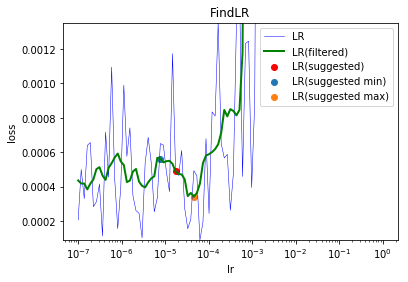

lr= 1.7378008287493757e-05, lr_min=7.76247116628692e-06, lr_max=4.57088189614875e-05


In [31]:
lr,(lr_min,lr_max,_)= FindLR(net, opt=opt, f_loss=f_loss, dl_train=dl_train, tfm_batch=tfm_batch, device=device)
print(f'lr= {lr}, lr_min={lr_min}, lr_max={lr_max}')

loss(train)	loss(test)	metric(test)	time
0.00037450	0.00099906	0.03090559	1.428520
0.00043302	0.00097134	0.03049721	1.408727
0.00041434	0.00117555	0.03347246	1.362601
0.00048721	0.00094670	0.03017962	1.445269
0.00044956	0.00111723	0.03284731	1.426254
0.00043349	0.00097825	0.03073804	1.461206
0.00035061	0.00095770	0.03030926	1.376141
0.00032676	0.00094363	0.03017824	1.426588
0.00031663	0.00093770	0.03004943	1.414359
0.00031563	0.00093764	0.03004897	1.295252


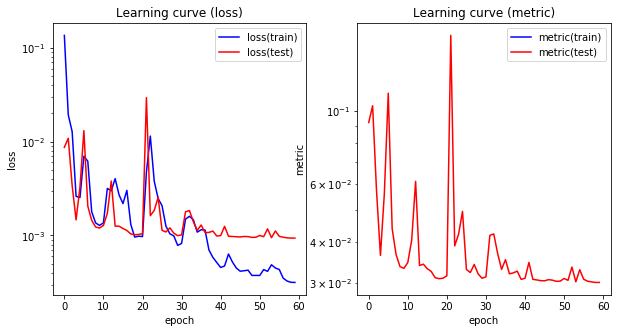

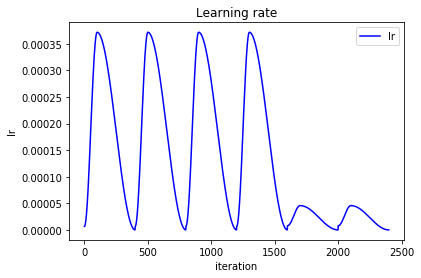

In [33]:
FitOneCycle(net, n_epoch=10, lr_max=lr_max, div_init=lr_max/lr_min, 
    opt=opt, f_loss=f_loss, f_metric=f_metric,
    dl_train=dl_train, dl_test=dl_test, tfm_batch=tfm_batch,
    callbacks=(logger.Callbacks(),disp.Callbacks()),
    device=device)
logger.Plot()
logger.PlotLR()

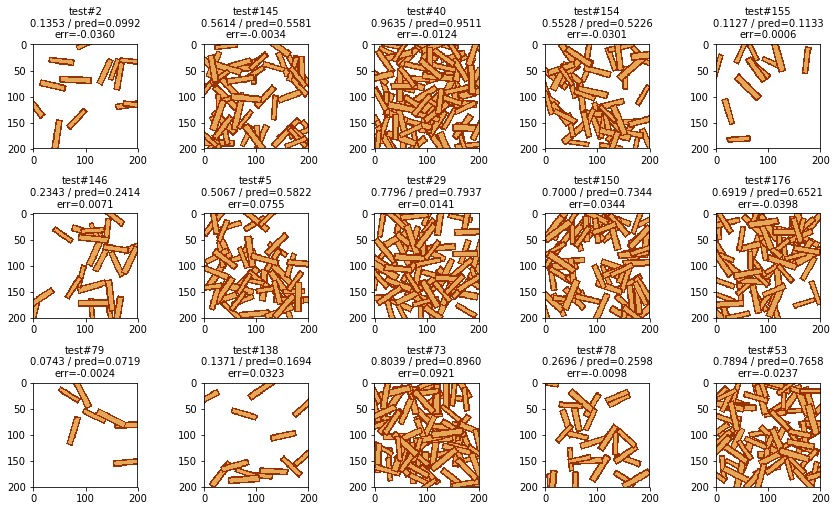

In [34]:
d= dset_test
idxes= np.random.permutation(len(d))[:15]
imgs= [d[i][0] for i in idxes]
pred= decode(Eval(net,imgs,device=device)).cpu()
labels= [f'test#{i}\n{d[i][1].item():.4f} / pred={lp.item():.4f}\nerr={lp.item()-d[i][1].item():.4f}' for i,lp in zip(idxes,pred)]
PlotImgGrid(imgs, labels)